In [1]:
import optax

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from sklearn.model_selection import train_test_split
from jax import random
from dataclasses import asdict

from src.gaussian_measures import GaussianProcess
from src.kernels.base_kernels import GaussianKernel, ARDKernel

jax.config.update("jax_enable_x64", True)

# Generate Random Data

In [2]:
seed = 42
np.random.seed(seed)
key = random.PRNGKey(seed)
key, subkey = random.split(key)
x = jnp.sort(10 * random.uniform(subkey, shape=(100, 1)), axis=0)
key, subkey = random.split(key)
y = jnp.sin(x) + 1e-2 * random.normal(subkey, shape=x.shape)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)
x_test_idx = jnp.argsort(x_test, axis=0)
x_test = x_test[x_test_idx]
y_test = y_test[x_test_idx]

# Gaussian Process

In [3]:
kernel = GaussianKernel()
kernel_parameters = kernel.Parameters(log_sigma=jnp.log(1.0))

gaussian_process = GaussianProcess(kernel, x_train, y_train)
gaussian_process_parameters = GaussianProcess.Parameters(
    log_sigma=jnp.log(1.0), kernel=kernel_parameters
)
gaussian_process_parameters

GaussianProcessParameters(log_sigma=DeviceArray(0., dtype=float64, weak_type=True), kernel=GaussianKernelParameters(log_sigma=DeviceArray(0., dtype=float64, weak_type=True)))

## Visualisation pre-hyperpaarameter optimisation

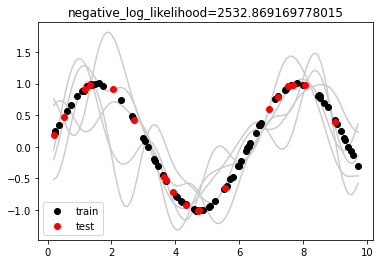

In [4]:
negative_log_likelihood = float(
    gaussian_process.posterior_negative_log_likelihood(
        x_test, y_test, **asdict(gaussian_process_parameters)
    )
)
x_plot = jnp.linspace(jnp.min(x), jnp.max(x), 100).reshape(-1, 1)
mean_plot, covariance_plot = gaussian_process.posterior_distribution(
    x_plot, **asdict(gaussian_process_parameters)
)
for _ in range(5):
    plt.plot(
        x_plot,
        np.random.multivariate_normal(mean_plot, covariance_plot, size=1).reshape(-1),
        color=(0.8, 0.8, 0.8),
        zorder=-1,
    )
plt.title(f"{negative_log_likelihood=}")
plt.scatter(x_train, y_train, color="k", zorder=1, label="train")
plt.scatter(x_test, y_test, color="r", zorder=1, label="test")
plt.legend()
plt.show()

## Hyperparameter Optimisation

In [5]:
learning_rate = 1e-1
optimizer = optax.adam(learning_rate)
number_of_iterations = 5000
gaussian_process_parameters = gaussian_process.train(
    gaussian_process_parameters, x_test, y_test, optimizer, number_of_iterations
)
gaussian_process_parameters

GaussianProcessParameters(log_sigma=DeviceArray(-2.37203472, dtype=float64), kernel={'log_sigma': DeviceArray(1.67893137, dtype=float64)})

## Visualisation post-hyperpaarameter optimisation

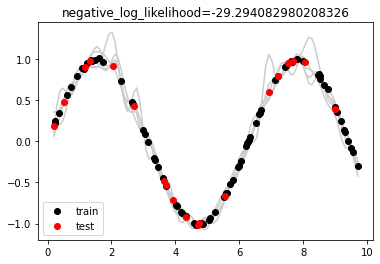

In [6]:
negative_log_likelihood = float(
    gaussian_process.posterior_negative_log_likelihood(
        x_test, y_test, **asdict(gaussian_process_parameters)
    )
)
x_plot = jnp.linspace(jnp.min(x), jnp.max(x), 100).reshape(-1, 1)
mean_plot, covariance_plot = gaussian_process.posterior_distribution(
    x_plot, **asdict(gaussian_process_parameters)
)
for _ in range(5):
    plt.plot(
        x_plot,
        np.random.multivariate_normal(mean_plot, covariance_plot, size=1).reshape(-1),
        color=(0.8, 0.8, 0.8),
        zorder=-1,
    )
plt.title(f"{negative_log_likelihood=}")
plt.scatter(x_train, y_train, color="k", zorder=1, label="train")
plt.scatter(x_test, y_test, color="r", zorder=1, label="test")
plt.legend()
plt.show()